# Predicting Strokes from Admission Data

**In this exercise we are going to try to predict strokes from admission data using various machine learning models**

This exercise uses a [stroke dataset from Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

Like other exercises, this is a **classification problem** - where we will try to determine if people have a stroke or not from some commonly used clinical metrics. We will also learn about the problem of **_class imbalance_**: a particularly common issue in healthcare - and learn about some approaches to over coming it. Furthermore, we will learn how to **use data pipelines**: an approach that helps us clean and and transform our data into a form which is more effective for machine learning algorithms to interpret and learn with.


In this exercise, we'll learn how to:
- **Download data** and **load it into our Jupyter Notebook**
- Import useful libraries like **pandas**, **sci-kit learn**, and **imbalanced-learn**
- **Clean our data**, and **modify it with sci-kit learn pipelines**
- Explore how we can manage **class imbalance**
- Quantify our model with **various metrics**

## Part 1: Downloading and Importing Data
To begin with, let's setup our notebook with the necessary packages as well as grab the data from Kaggle!

One option for doing this, is to set up a virtual environment on your computer. Popular virtual environments for Python are venv and conda. Here are some guides on how to do so: [**1**](https://protostar.space/why-you-need-python-environments-and-how-to-manage-them-with-conda) and [**2**](https://realpython.com/python-virtual-environments-a-primer/).

The easiest way to get started, however, is just to run a "command line argument" from directly within our Jupyter notebook. We can do that by adding "%" to the start of our Jupyter Notebook cell. (This means we don't have to run it in a separate terminal.)

In [ ]:
%pip install pandas numpy matplotlib seaborn imbalanced-learn

This makes sure our environment/colab instance has installed the latest versions of several commonly used data science packages.

In [ ]:
# Setup matplotlib to display plots correctly within pandas
%matplotlib inline

# Import packages into our runtime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

### Download from Kaggle

Option #1. Using Kaggle CLI Command

Those who have downloaded and setup the kaggle CLI (Command Line Interface) can run the following command to download the dataset:



In [ ]:
# Download the stroke prediction dataset into the ./data folder
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset --path ./data


Option #2. Download manually

You can view information about the dataset and download it [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). (You may need to create a Kaggle account, which is definitely worth doing - Kaggle is great.)

Downloading and moving our data
Once we've downloaded the data, we're looking for the .csv file (it may be within a .zip file, which needs unzipping). CSV stands for 'comma-separated value' and refers to the fact that each row of data is stored with values that are separated by commas. You can open the file in a 'plain text' editor (like Notepad (windows) or TextEdit (Mac)) to see what this looks like.

Where we put that file will depend on whether we're running Jupyter Notebook locally or in Google Colab. These options are discussed in the Jupyter Notebook setup exercise.

If you are using Google Colab, you need to:

Make sure you are connected to a runtime (click Connect in the top right, if you aren't)
Select the 'Files' folder on the left hand tab
Drag our downloaded  'healthcare-dataset-stroke-data.csv' file into the Files tab (it should show the file uploading in the bottom left, and then you'll see 'healthcare-dataset-stroke-data.csv' within the Files tab).
If you are running Jupyter Notebook on your local computer, you can simply:

Drag our 'healthcare-dataset-stroke-data.csv' file into the same folder (aka. directory) as this Jupyter Notebook.


## Part 2: Data Exploration
Now we have the data downloaded, we need to load this into a dataframe so we can explore it, and perform further analysis.

We can either do this by unzipping the dataset or just loading it directly with pandas:

In [ ]:
# No need to unzip the file - we can load the .csv file within directly into a DataFrame (commonly notated as `df`)
df = pd.read_csv("./healthcare-dataset-stroke-data.csv")
df = df.rename({"Residence_type": "residence_type"}, axis=1)

It is good practice to explore what data we are actually dealing with and get a *feel* for it. We should check for missing data, what data is present, and relevant datatypes!

There are many ways of doing this with `pandas` ([API](https://pandas.pydata.org/docs/reference/frame.html#attributes-and-underlying-data)) - the most useful and commonly used methods being `head()`, `info()`, `describe()` initially:

In [ ]:
# Let's have a look at the first 10 entries of the dataset
df.head(10)

 **Excute the 2 following commands , *df.info()* and *df.describe()*, describe the returned results and the diffrence between the two comannds** 

In [ ]:
df.info()

In [ ]:
df.describe()

Describe is useful for looking at continuous data (i.e. int or float datatypes) - we can see it also has a look at data which is stored as booleans, as well as ID's (i.e. the id, hypertension, heart_disease, and stroke coluns)

In [ ]:
# We can exclude the boolean or ID data by selecting certain rows for example

df[["age", "avg_glucose_level", "bmi"]].describe()

### Graphing

We can explore the data further by :

- Plotting the distribution of some continous variables,
- Number of cases of stroke vs non-stroke, to check whether the dataset is imbalanced,
- Plotting discrete variables using a bar chart

#### Continuous Variables

In [ ]:
continuous_features = ["age", "avg_glucose_level", "bmi"]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for idx, feature in enumerate(continuous_features):
    sns.histplot(data=df, x=feature, ax=ax[idx], kde=True)
plt.show()

In [ ]:
df["stroke"].value_counts(normalize=True).plot(kind="pie", autopct="%.2f")
plt.xlabel("Stroke")
plt.ylabel("Percentage")

We can see that the vast majority of our dataset have not had a stroke - infact less than 5% have.

We will explore the implications of this later...

#### Discrete Variables

In [ ]:
discrete_features = ["ever_married", "work_type", "residence_type", "smoking_status"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for idx, axis in enumerate(fig.axes):
    sns.histplot(df[discrete_features[idx]], ax=axis)
    axis.tick_params(labelrotation=30)


plt.show()

## Part 3: Preparing our Data for Model Training
Now we have a feel for our dataset, we can begin building a useful model to try and predict outcomes

### 3a. Data Pre-processing

One common problem with real-world datasets is missing data or outliers. We can check the number of missing values with the isna() function. 
This will return a table which shows whether each cell is a NaN or not.

We can find the total number of NaNs in each column of our table using the following cell.


In [ ]:
df.isna().sum()

We can see we are missing 201 BMI values: at this point we have two options, to either drop the rows which are missing data, or to _impute_ their values. In this case, we will go for the latter!

There are more complex approaches to doing this - which can be done using the [`sklearn.imputer`](https://scikit-learn.org/stable/modules/impute.html) classes.

**Calculate the mean of BMI column and use it to fill missing values**

In [ ]:
# First calculate the average
mean_bmi = df["bmi"].mean()

# Now fill missing values with this mean
df["bmi"] = df['bmi'].fillna(mean_bmi)

# Check that our commands have worked!
df.isna().sum()

In [ ]:
# We can get rid of 'ID' column, this isn't needed!
# df = df.drop(columns=["id"])

# We can then develop our `X` and `y` sets
X = df.drop(columns=["stroke"])
y = df["stroke"]

In [ ]:
# Can you check if we have the right shape of data - we should have 5110 rows, with 10 features in the X set - and only a column of 1 or 0 in the y column
print()
print()

#### Train-Test Splits

Using our input **features** we have stored in the variable `X` (gender, age, hypertension, heart disease, marriage, work type, residence type, glucose level, BMI, smoking status), we can try to predict the output class for each case (`y`).

However, in order to train and test our models we need to split the data up into `train` and `test` bins in order to make sure that the models we make haven't _'seen'_ the test data to ensure they're working as we want.

![image.png](attachment:image.png) 
<sup>[image source](https://medium.com/@rinu.gour123/train-and-test-set-in-python-machine-learning-how-to-split-58029a0d657b)</sup>

It's sort of like running an exam - the exam is pointless if everybody has already seen the questions beforehand!

To do this we import the function `train_test_split` from `sklearn`, and then split the data up as below - we set the test_size to be 20% of the overall dataset size:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2023
)

### 3b. Data Encoding
Many machine learning algorithms are sensitive to how **continuous data** (e.g. Age, BMI) and **categorical data** (e.g. Hypertension, Smoking status) are provided.

### 1 - Continuous data

For **continuous data**, it's important to consider **normalising** and **standardising** the data:

#### Min-Max Scaling

Min-Max scaling, also known as **Normalisation**, is where the range of values is compressed to a set range: usually between 0 and 1 (neural networks in particular tend to expect their inputs to be between this range). This method is sensitive to outliers however, as the smallest and largest value are used for 0 and 1 in the new scale respectively. Let's see what happens if we min-max scale average glucose values:

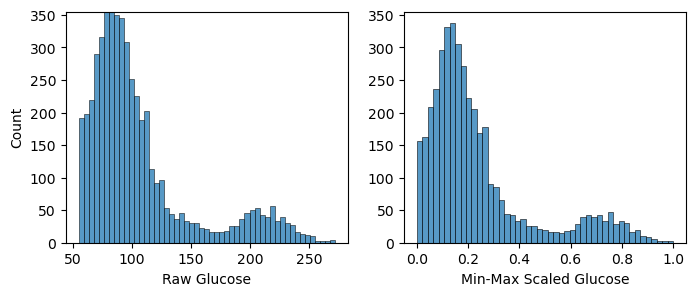


#### Standardisation

ML Algorithms tend to perform worse if data have very different scales. For example, if we look at our BMI data, we can see that the range of values is quite wide: the lowest value is 10.3 - where the largest is 97.6! However the majority of values lie between 20 and 40; this large can trip up some algorithms. 

To combat this we can "standardise" the data to a new scale, where 0 is the average. For example we can do this to our BMI below (look at the x axis scale):

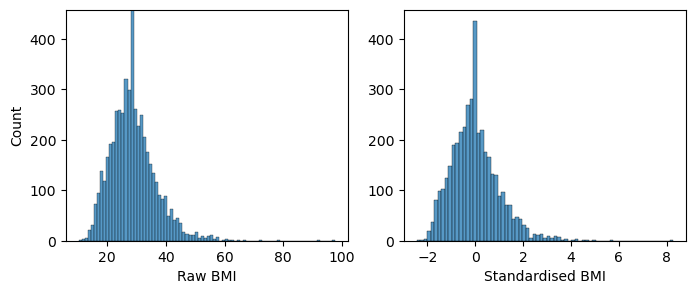

Now the average of $28.9$ has been shifted to $0$, and we have negative values! The advantage of this method is that the values of outliers are suppressed, and they have a reduced size.


In our case, we'll use the `StandardScaler` function from `sklearn`. Let's import and define it:

In [ ]:
from sklearn.preprocessing import StandardScaler
numerical_transformer = StandardScaler()

Now let's look at the other type of data: **categorical data**.

### 2 - Categorical Data
Here, we want to consider the different types of categories, whcih could be Named, Ordinal or Nominal.

#### Named Categories

Machine learning algorithms and neural networks at a low level canot work on text values (it has no inherent meaning to them), and we need to convert these into a number representation for them: for example if we look at `gender` we have `Male` and `Female` as strings. We need to convert these into numeric equivalents. We can do this by hand in python by running something like:

```python
df['Gender'] = df[df['Gender'] == 'Male] = 0
df['Gender'] = df[df['Gender'] == 'Female] = 1
```

This becomes increasingly cumbersome and time-consuming if doing this over a large range of values: `sklearn` provides us some tools to do this for us: we can use the `LabelEncoder` or `OrdinalEncoder` to convert labels to numbers automatically! 

We'll use `OrdinalEncoder` instead of `LabelEncoder` as it can process multiple columns at once! Let's import it, to get ready:

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
label_transformer = OrdinalEncoder()

#### Ordinal Categories

`LabelEncoder` works well for cases where we only have two categories. However what about cases where the order (i.e. ordinal data) of the values are important: for example the order of income classes low, medium, high should be 0, 1, 2, for example, and not 2, 0, 1. The `OrdinalEncoder` can handle this for us in cases where the order matters by explicity which value should be mapped to a certain number.


#### Nominal Categories

Finally, some categories are unordered however, and we **do not** want them to be labelled as a rank: for example, it would be problematic if we started treating blood type or ethnicity as ordinal data - as one class would be treated as a 'greater' value as another. 

In our data we have work type (`Private, Self-employed, children, Govt_job, Never_worked`) as categorical data that we want as nominal (unordered) catergoies. We can use "One Hot Encoding" to process into "one hot" columns so the machine learning algorithms will look at each class individually; for example:

| Work Category | →| work_private | work_selfEmployed | work_children | work_govt | work_never |
| ------------- | - | ------------ | ----------------- | ------------- | --------- | ---------- |
| private       |  | 1            | 0                 | 0             | 0         | 0          |
| selfEmployed  |  | 0            | 1                 | 0             | 0         | 0          |
| children      |  | 0            | 0                 | 1             | 0         | 0          |
| govt          |  | 0            | 0                 | 0             | 1         | 0          |
| children      |  | 0            | 0                 | 1             | 0         | 0          |
| never         |  | 0            | 0                 | 0             | 0         | 1          |

The final encoder `sklearn` tools we'll use for this is `OneHotEncoder`, so let's import that too:

In [ ]:
from sklearn.preprocessing import OneHotEncoder
nominal_transformer = OneHotEncoder()

### Defining our column types

We need to define all the columns in our dataset based on how we want to pre-process them: as numerical variables as nominal (categorical) variables or as Named "labelled" (categorical) variables. For some variables, we won't need to do anything with them, so we can include them as `pass_columns`.

In [ ]:
numerical_columns = ["age", "avg_glucose_level", "bmi"]
nominal_columns = ["work_type", "smoking_status"]

# These are columns we don't want to modify as they're already in a good form for ML training
pass_columns = ["hypertension", "heart_disease"]


**Define the label_columns to include the suitable columns which have strings and we want to convert to labels. Have a look at the dataframe and decide!**

In [ ]:
label_columns = ["gender", "ever_married", "residence_type"]

### 3c. using Data Pipelines

We can use `sklearn` pipelines and column transformers in order to easily apply this methods to large datasets with different datatypes and many columns easily!

In the pipline, we'll string several actions together, whilst column transformers let us choose which columns we might want to perform certain transformations to.

In [ ]:
# Import the relevant classes from Sklearn!
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

Let's define an run our pipeline:

In [ ]:
pipeline = ColumnTransformer(
    [
        ("num", numerical_transformer, numerical_columns),
        ("ord", nominal_transformer, nominal_columns),
        ("lab", label_transformer, label_columns),
    ],
    # We want to include columns in the dataframe that are already in a suitable format for ML!
    remainder="passthrough",
)

X_train_prep = pipeline.fit_transform(X_train)

In [ ]:
prep_df = pd.DataFrame(X_train_prep)
prep_df.columns = pipeline.get_feature_names_out()
prep_df.head()


You may remember from previous exercises the data leakage notion, we only TRANSFORM the test data

In [ ]:
# Now we need to scale the test data which we haven't yet touched
X_test_prep = pipeline.transform(X_test)

## Part 4: Making our First Model

Now we have imported, cleaned, and transformed our data - it is finally in a form that we can make models to help us predict future strokes.

To begin with, we will use a Logistic Regression to make these predictions.

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_prep, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# we can now predict some strokes in our test dataset - which our model has not seen!
y_pred = logistic_regression.predict(X_test_prep)
print(accuracy_score(y_test, y_pred))

#### 🤔 Something Fishy Afoot

Hmmm... our model has a pretty a pretty good "accuracy" - however if we look deeper something odd is going on.

Let's have a look at what are model is guessing

In [ ]:
y_pred.sum()  # Add's up how many 1's there are (i.e. how many people we have predicted have had a stroke)

Essentially our model just guesses `0` / no stroke every time and get's a pretty good accuracy.

For imbalanced class problems (a common and important issue in medicine!) we need to dive deeper other metrics are more useful to understand how well our model truly works. You may remember from previous exercises the F1 Score ~ which provides a metric of how well a model is at making true positives/negatives and false positives/negatives. Unfortunately, there will always be a trade off between these - and one we need to keep in mind when designing machine learning models in healthcare.

The F1 score is a *harmonic mean* of the Precision and Recall:

$$\text{F1 Score} = 2\times\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2TP}{2TP + FP + FN}$$

We have to make decisions when we tune our model if we want more *false positives* or more *false negatives* - with real world implications. If we were deploying our model, we would have to decide if we would rather have fewer false positives - and the run risk of missing potential strokes - or predict more people were having strokes when they aren't, and run the risk of over investigation and unrequired treamtment/intervention.

If you would like to learn more about this it is well worth looking at the [Machine Learning University's explainer on Precision and Recall](https://mlu-explain.github.io/precision-recall/) which nicely demonstrates how the precision-recall tradeoff works visually.

In [ ]:
print(f"F1 Score: {f1_score(y_test, y_pred)}")

The F1 Score is 0 in this case, as the model doesn't predict any cases of stroke - and so the numerator is 0 (no True Positives!).

Let's check more complicated models also suffer from the same issue - to check that this isn't purely as a result of [Logistic Regression](https://mlu-explain.github.io/logistic-regression/) being unable to capture complicated relationships.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

svm = SVC()
forest = RandomForestClassifier()
gbm = GradientBoostingClassifier()

for model in (svm, forest, gbm):
    model.fit(X_train_prep, y_train)
    y_pred = model.predict(X_test_prep)

    print(f"F1 Score ({type(model).__name__}): {f1_score(y_test, y_pred)}")

## Part 5: Tackling Unbalanced Datasets
An unbalanced dataset is where a *class* or outcome is much less common than another: in this case the vast majority of people don't have strokes. This can lead machine learning models to tend to predict a common class (`no stroke`) over a minority/rare class (`stroke`) as it has receives many more examples of one class over another, and is unable to learn what differentiates the two.

There are various ways of approaching unbalanced datasets like these, which we will explore now:

### Get More Data
In an ideal world, we could simply collect more data to represent the *minority* class, however this is not always easy or feasible. We would have to wait many months or years to collect lots of data for strokes for example!

### Weighting/Model Penalization
We can 'penalize' our model to put a greater weighting on a minority class. In essence, this forces the model to pay more attention to the minority class.

### Resampling
Essentially we are manipulating our dataset so there is a ratio of classes closer to 50:50. There are two approaches within this:
 1. **Undersampling** - where we take a sample (either randomly, or through more intelligent means) of the **majority** class, so that the ratio is limited, or
 2. **Oversampling** - where we expand the number of **minority** class: we can do this by duplicating instances of the minority class, or we can synthesise examples of this class.

This is nicely visualised below <sup>([ref](https://blog.strands.com/unbalanced-datasets))</sup>

<img src="https://blog.strands.com/hs-fs/hubfs/Screenshot%202019-07-18%20at%2014.15.15.png?width=1200&name=Screenshot%202019-07-18%20at%2014.15.15.png" width=700>




### Getting More Data

Sadly, we can't get more data in this case - but what we can do is make sure the *train* and *test* set have equal numbers of each class. Fortunately `sklearn` makes this easy to do when we split our model, so we don't have to worry about one size being bigger than the other!

In [ ]:
# In this case - we are forcing the percentages of strokes to be the same in the train and test class
# This is done be setting the stratify command to our outcome column of strokes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# We now need to pass our data through our pipeline again!
X_train_prep = pipeline.fit_transform(X_train)
X_test_prep = pipeline.transform(X_test)

Sadly, this is unlikely to make much difference - as by pure chance there would likely be a similar number of strokes in the test and train set anyway.

### Model Penalisation

We can teach our model to pay more attention to each class by putting a 'weight' on each class. Fortunately this is easy to do in sklearn with the `class_weight` attribute!

In [ ]:
# === Class Weighting ===
# We will begin with adjusting class weights as this is easy to do in the first instance
logistic_regression = LogisticRegression(class_weight="balanced")

# Fit our model
logistic_regression.fit(X_train_prep, y_train)

# Make some predictions
y_pred = logistic_regression.predict(X_test_prep)

# See how well it performs
print(f"Accuracy Score (Logistic Regression): {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score (Logistic Regression): {f1_score(y_test, y_pred):.4f}")

In [ ]:
# Lets try more complicated models
svm = SVC(class_weight="balanced")
forest = RandomForestClassifier(class_weight="balanced")

for model in (svm, forest):
    model.fit(X_train_prep, y_train)
    y_pred = model.predict(X_test_prep)

    print(f"F1 Score ({type(model).__name__}): {f1_score(y_test, y_pred)}")

We can see that we finally have an F1 score greater than 0m, and our Logistic regression model is performing the best at the moment. 

### Under and Over Sampling

We can also combine data undersampling and oversampling on a training dataset.
Data undersampling will delete examples from the majority class, whereas data oversampling will add examples to the minority class. These two approaches can be combined and used on a single training dataset.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

under = RandomUnderSampler(sampling_strategy=0.1)
over = RandomOverSampler(sampling_strategy=0.5)
model = LogisticRegression()

X_under, y_under = under.fit_resample(X_train_prep, y_train)
X_combined, y_combined = over.fit_resample(X_under, y_under)

**Run the following models using combined technique and comment the obtained accuracy,**

In [ ]:


logreg = LogisticRegression()
svm = SVC()
forest = RandomForestClassifier()
knn = KNeighborsClassifier()
gbm = GradientBoostingClassifier()

for model in (logreg, svm, forest, knn, gbm):
    model.fit(X_combined, y_combined)
    y_pred = model.predict(X_test_prep)

    print(f"F1 Score ({type(model).__name__}): {f1_score(y_test, y_pred)}")

# Next Steps
Have a go at modifying our pipeline, including:

- Engineering your own features
- Different parameters (such as different train/test splits)
- Different models (see below)

Popular classifiers to try as alternative models include:

- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [K-nearest neighbours](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [suppor vector machines (SVMs)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Gradient Boosting Machines (aka XGBoost)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

These links will take you to the documentation. See if you can work out how to import them and then train the model based on the description and examples that they provide.


Fill out the form below and we'll provide feedback on your code.

**Any feedback on the exercise? Any questions? Want feedback on your code? Please fill out the form [here](https://docs.google.com/forms/d/e/1FAIpQLSdoOjVom8YKf11LxJ_bWN40afFMsWcoJ-xOrKhMbfBzgxTS9A/viewform).**